Load & quick EDA

In [23]:
import pandas as pd
df = pd.read_csv("/content/loan_approval_dataset.csv")    # replace filename as needed



In [25]:
print(df.shape)
print(df.columns.tolist())
print(df[' loan_status'].value_counts(dropna=False))  # target example; adjust column name
print(df.isna().sum().sort_values(ascending=False).head(10))
df.head()

(4269, 13)
['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']
 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64
loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
dtype: int64


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Preprocessing plan (automatic, robust)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline # Import Pipeline
from imblearn.over_sampling import SMOTE

# assume df loaded and target col name known
TARGET = ' loan_status'   # adjust
# convert target to binary 0/1 (already done in previous cell)
# df[TARGET] = df[TARGET].str.strip().map({'Approved':1, 'Rejected':0}) # Removed this line

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# detect types
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# transformers
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Changed sparse to sparse_output
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

Train/test split (stratified)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Logistic Regression with class_weight

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

pipeline_lr = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.8779    0.9350    0.9055       323
           1     0.9588    0.9209    0.9395       531

    accuracy                         0.9262       854
   macro avg     0.9184    0.9279    0.9225       854
weighted avg     0.9282    0.9262    0.9266       854



Decision Tree (no scaling required)

In [33]:
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

pipeline_dt.fit(X_train, y_train)
print(classification_report(y_test, pipeline_dt.predict(X_test), digits=4))


              precision    recall  f1-score   support

           0     0.9842    0.9628    0.9734       323
           1     0.9777    0.9906    0.9841       531

    accuracy                         0.9801       854
   macro avg     0.9809    0.9767    0.9787       854
weighted avg     0.9801    0.9801    0.9800       854



Handle imbalance with SMOTE

In [34]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

pipeline_lr_smote = ImbPipeline([
    ('pre', preprocessor),
    ('smote', smote),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_lr_smote.fit(X_train, y_train)
print(classification_report(y_test, pipeline_lr_smote.predict(X_test), digits=4))


              precision    recall  f1-score   support

           0     0.8801    0.9319    0.9053       323
           1     0.9570    0.9228    0.9396       531

    accuracy                         0.9262       854
   macro avg     0.9186    0.9273    0.9224       854
weighted avg     0.9279    0.9262    0.9266       854



Evaluation focus: precision / recall / F1 (and PR curve)

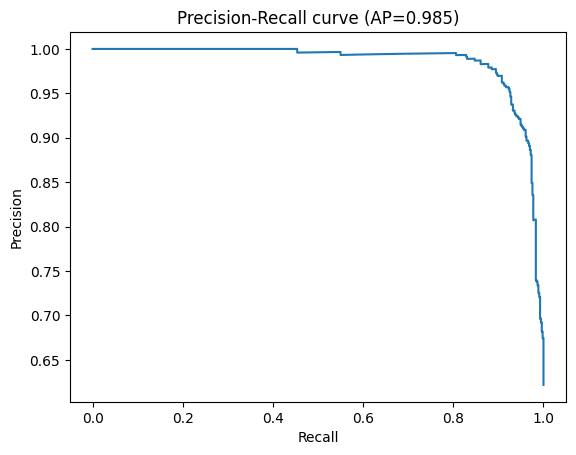

In [35]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_scores = pipeline_lr_smote.predict_proba(X_test)[:,1]
precision, recall, thresh = precision_recall_curve(y_test, y_scores)
ap = average_precision_score(y_test, y_scores)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AP={ap:.3f})")
plt.show()


Hyperparameter tuning

In [36]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'clf__max_depth': [3, 5, 8, None],
    'clf__min_samples_leaf': [1, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_dt_smote = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

gs = GridSearchCV(pipeline_dt_smote, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV f1:", gs.best_score_)
print(classification_report(y_test, gs.predict(X_test), digits=4))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 10}
Best CV f1: 0.9804214222327012
              precision    recall  f1-score   support

           0     0.9662    0.9721    0.9691       323
           1     0.9830    0.9793    0.9811       531

    accuracy                         0.9766       854
   macro avg     0.9746    0.9757    0.9751       854
weighted avg     0.9766    0.9766    0.9766       854



Save best model

In [37]:
import joblib
joblib.dump(gs.best_estimator_, 'best_loan_model.joblib')


['best_loan_model.joblib']

Loan Status Distribution

/tmp/ipython-input-3914973994.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=" loan_status", data=df, palette="Set2") # Corrected column name


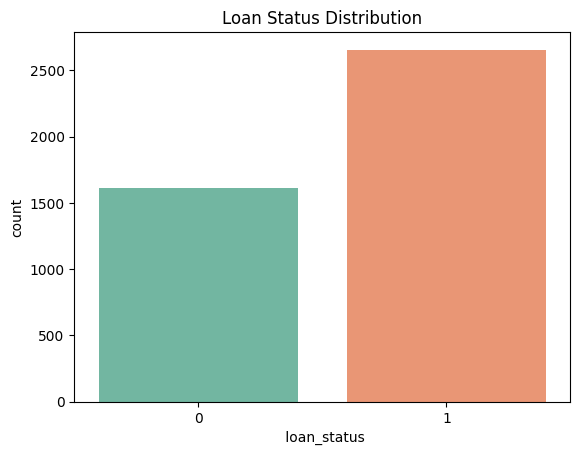

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=" loan_status", data=df, palette="Set2") # Corrected column name
plt.title("Loan Status Distribution")
plt.show()

Gender vs Loan Status

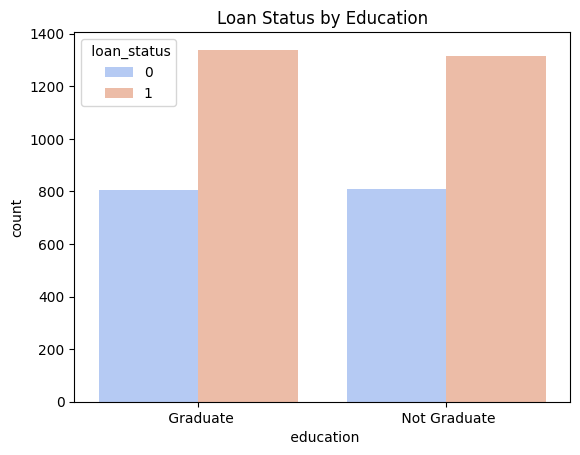

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=" education", hue=" loan_status", data=df, palette="coolwarm") # Changed 'Gender' to ' education' and 'Loan_Status' to ' loan_status'
plt.title("Loan Status by Education") # Updated title
plt.show()

Education vs Loan Status

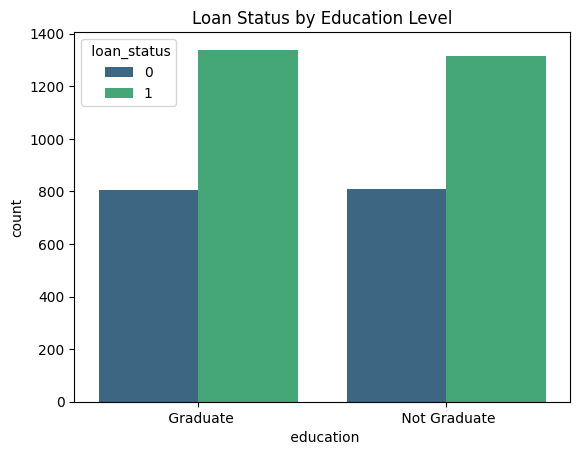

In [44]:
sns.countplot(x=" education", hue=" loan_status", data=df, palette="viridis") # Corrected column names
plt.title("Loan Status by Education Level")
plt.show()

Applicant Income Distribution

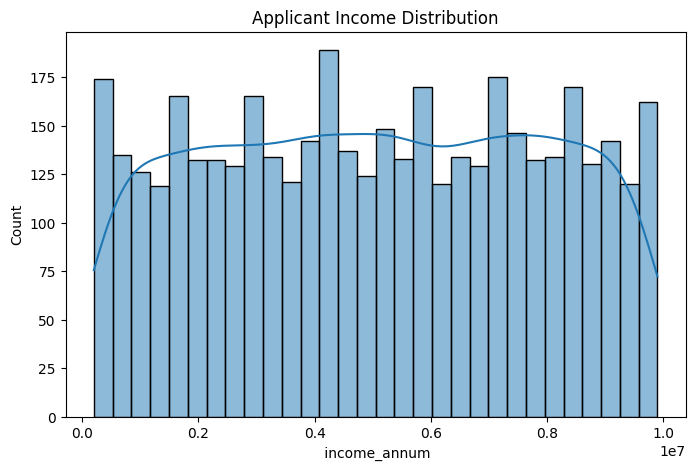

In [46]:
plt.figure(figsize=(8,5))
sns.histplot(df[" income_annum"], bins=30, kde=True) # Corrected column name
plt.title("Applicant Income Distribution")
plt.show()

Loan Amount vs Loan Status (Boxplot)

/tmp/ipython-input-3942788015.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=" loan_status", y=" loan_amount", data=df, palette="Set1") # Corrected column names


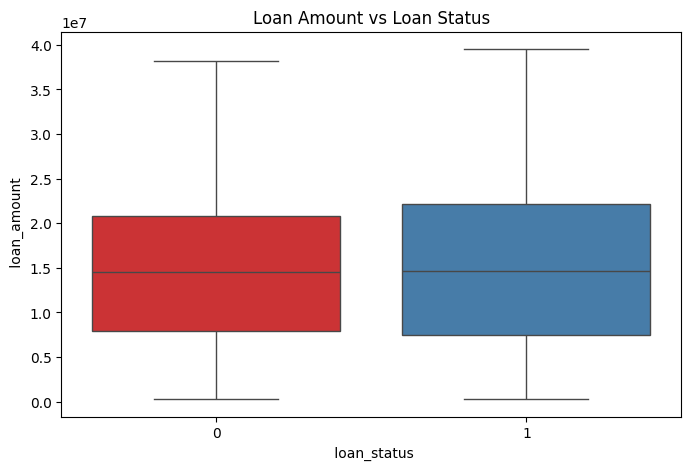

In [48]:
plt.figure(figsize=(8,5))
sns.boxplot(x=" loan_status", y=" loan_amount", data=df, palette="Set1") # Corrected column names
plt.title("Loan Amount vs Loan Status")
plt.show()

Correlation Heatmap

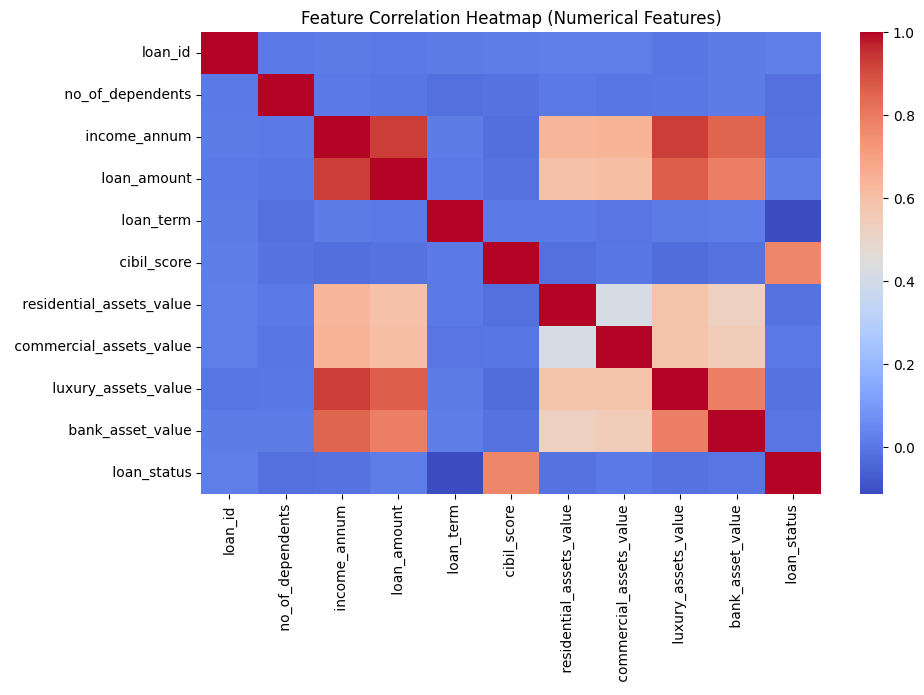

In [50]:
plt.figure(figsize=(10,6))
numerical_df = df.select_dtypes(include=['int64', 'float64']) # Select only numerical columns
sns.heatmap(numerical_df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Numerical Features)")
plt.show()